In [11]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define file path and tree names
files = [
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection"),
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GGJets/preselection"),
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt20To40/preselection"),
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt40/preselection")
]
keys = [
    'dibjet_mass',
    'diphoton_mass',
    'bbgg_mass',
    'dibjet_pt',
    'diphoton_pt',
    'bbgg_pt',
    'lead_pho_pt',
    'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    'lead_pt_over_diphoton_mass',
    'sublead_pt_over_diphoton_mass',
    'lead_pt_over_dibjet_mass',
    'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
    'weight_preselection',
]


# Initialize an empty dictionary to store dataframes
dfs = {}

# Loop through each file and load the corresponding dataframe
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(keys, library="pd")

# Access your dataframes by key
signal_df = dfs["/GluGluToHH/preselection"]
background_df_1 = dfs["/GGJets/preselection"]
background_df_2 = dfs["/GJetPt20To40/preselection"]
background_df_3 = dfs["/GJetPt40/preselection"]


weight = 'weight_preselection'

print('singal df', signal_df.shape)
print('background_df_1 ', background_df_1.shape)
print('background_df_2', background_df_2.shape)
print('background_df_1 ', background_df_3.shape)


background_df = pd.concat([background_df_1, background_df_2, background_df_3], ignore_index=True)
# background_df = background_df_1
print('background_df', background_df.shape)

signal_df['label'] = 1
background_df['label'] = 0

combined_df = pd.concat([signal_df, background_df], ignore_index=True)

singal df (131972, 41)
background_df_1  (46802, 41)
background_df_2 (9867, 41)
background_df_1  (41966, 41)
background_df (98635, 41)


In [12]:
signal_df

,dibjet_mass,diphoton_mass,bbgg_mass,dibjet_pt,diphoton_pt,bbgg_pt,lead_pho_pt,sublead_pho_pt,bbgg_eta,bbgg_phi,...,FirstJet_PtOverM,SecondJet_PtOverM,lead_pt_over_diphoton_mass,sublead_pt_over_diphoton_mass,lead_pt_over_dibjet_mass,sublead_pt_over_dibjet_mass,diphoton_bbgg_mass,dibjet_bbgg_mass,weight_preselection,label
0,103.144596,125.955761,574.322383,268.093942,258.570016,81.698283,189.193506,75.013507,2.846664,-0.153605,...,1.926903,0.805300,1.502063,0.595554,1.926907,0.805302,0.450218,0.466800,0.007069,1
1,80.740511,125.432341,377.817349,90.695718,197.665496,261.955830,148.496308,75.967723,-1.479571,-2.672223,...,0.933548,0.483804,1.183876,0.605647,0.933546,0.483803,0.523177,0.240052,0.007069,1
2,116.090599,124.604623,372.489217,94.767169,74.227589,20.547263,75.488691,49.486907,1.690543,-0.632461,...,1.010526,0.235942,0.605826,0.397151,1.010525,0.235942,0.199274,0.254416,0.007069,1
3,93.899284,126.250670,324.118930,121.457317,118.079254,46.214360,82.189497,71.435959,2.387711,-0.352606,...,0.822024,0.498872,0.651002,0.565826,0.822024,0.498872,0.364308,0.374731,0.007069,1
4,120.817461,125.939360,670.488457,249.724129,171.922322,298.349502,154.138931,41.535176,-0.645109,3.138045,...,2.091998,0.194120,1.223914,0.329803,2.091999,0.194120,0.256414,0.372451,0.007069,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131967,84.884352,127.008792,260.814502,21.376987,80.646438,76.028535,79.223850,57.160900,2.331852,1.945427,...,0.549645,0.457240,0.623767,0.450055,0.549645,0.457240,0.309210,0.081962,0.007069,1
131968,131.549817,124.027959,552.266926,248.855861,232.935552,15.934938,188.421611,46.136162,-3.613964,-2.635625,...,1.317942,0.791050,1.519187,0.371982,1.317942,0.791050,0.421781,0.450608,0.007069,1
131969,97.751287,123.732555,361.636176,124.775423,156.694356,32.971867,145.603967,53.958925,-2.088606,-1.183131,...,1.148962,0.455237,1.176764,0.436093,1.148962,0.455237,0.433293,0.345030,0.007069,1
131970,79.208156,122.636442,386.868607,158.331472,188.331511,121.431344,167.982539,55.832145,1.956132,1.549761,...,1.851135,0.336140,1.369760,0.455266,1.851135,0.336140,0.486810,0.409264,0.007069,1


In [13]:
combined_df


,dibjet_mass,diphoton_mass,bbgg_mass,dibjet_pt,diphoton_pt,bbgg_pt,lead_pho_pt,sublead_pho_pt,bbgg_eta,bbgg_phi,...,FirstJet_PtOverM,SecondJet_PtOverM,lead_pt_over_diphoton_mass,sublead_pt_over_diphoton_mass,lead_pt_over_dibjet_mass,sublead_pt_over_dibjet_mass,diphoton_bbgg_mass,dibjet_bbgg_mass,weight_preselection,label
0,103.144596,125.955761,574.322383,268.093942,258.570016,81.698283,189.193506,75.013507,2.846664,-0.153605,...,1.926903,0.805300,1.502063,0.595554,1.926907,0.805302,0.450218,0.466800,0.007069,1
1,80.740511,125.432341,377.817349,90.695718,197.665496,261.955830,148.496308,75.967723,-1.479571,-2.672223,...,0.933548,0.483804,1.183876,0.605647,0.933546,0.483803,0.523177,0.240052,0.007069,1
2,116.090599,124.604623,372.489217,94.767169,74.227589,20.547263,75.488691,49.486907,1.690543,-0.632461,...,1.010526,0.235942,0.605826,0.397151,1.010525,0.235942,0.199274,0.254416,0.007069,1
3,93.899284,126.250670,324.118930,121.457317,118.079254,46.214360,82.189497,71.435959,2.387711,-0.352606,...,0.822024,0.498872,0.651002,0.565826,0.822024,0.498872,0.364308,0.374731,0.007069,1
4,120.817461,125.939360,670.488457,249.724129,171.922322,298.349502,154.138931,41.535176,-0.645109,3.138045,...,2.091998,0.194120,1.223914,0.329803,2.091999,0.194120,0.256414,0.372451,0.007069,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230602,118.491979,122.265403,361.002012,98.639038,95.225941,5.804559,58.618575,53.568688,-2.978426,-2.862377,...,0.529308,0.303818,0.479437,0.438134,0.529308,0.303818,0.263782,0.273237,1.234159,0
230603,123.603086,107.676877,275.154930,27.125931,15.584894,42.703599,53.291322,38.441434,-0.918578,-0.072746,...,0.266984,0.208581,0.494919,0.357007,0.266984,0.208581,0.056640,0.098584,1.234159,0
230604,95.667121,207.577510,319.984620,33.871465,61.247438,27.686968,116.824789,55.581439,-3.428069,1.886743,...,0.256096,0.230617,0.562801,0.267762,0.256096,0.230617,0.191407,0.105853,1.234159,0
230605,184.603259,134.922750,397.160996,176.374632,41.189562,149.662868,71.833402,60.094018,-2.113904,-0.174919,...,0.909382,0.199414,0.532404,0.445396,0.909383,0.199414,0.103710,0.444089,1.234159,0


In [14]:
features = [
    'diphoton_mass',
    'dibjet_mass',
    'lead_pho_pt',
    'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    'lead_pt_over_diphoton_mass',
    'sublead_pt_over_diphoton_mass',
    'lead_pt_over_dibjet_mass',
    'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
]

X = combined_df[features]
y = combined_df['label']
weight = combined_df['weight_preselection']

In [15]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [16]:

X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'])

# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)


In [17]:
# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)




In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
def create_dnn_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Create the model
input_dim = len(features)  # Assuming 'features' is defined
model = create_dnn_model(input_dim)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Model summary
model.summary()

# Save the model summary to a file
os.makedirs("bdtplots/dnn", exist_ok=True)
with open("bdtplots/dnn/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model
model.load_weights('best_model.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               9472      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

/home/shivam-raj/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9225/9225 [==============================] - 23s 3ms/step - loss: 0.2171 - accuracy: 0.9219 - val_loss: 0.1873 - val_accuracy: 0.9281
Epoch 3/50
9225/9225 [==============================] - 26s 3ms/step - loss: 0.2084 - accuracy: 0.9261 - val_loss: 0.1486 - val_accuracy: 0.9530
Epoch 4/50
9225/9225 [==============================] - 26s 3ms/step - loss: 0.1921 - accuracy: 0.9344 - val_loss: 0.1430 - val_accuracy: 0.9642
Epoch 5/50
9225/9225 [==============================] - 24s 3ms/step - loss: 0.1966 - accuracy: 0.9314 - val_loss: 0.1286 - val_accuracy: 0.9645
Epoch 6/50
9225/9225 [==============================] - 25s 3ms/step - loss: 0.1997 - accuracy: 0.9302 - val_loss: 0.1779 - val_accuracy: 0.9376
Epoch 7/50
9225/9225 [==============================] - 25s 3ms/step - loss: 0.1916 - accuracy: 0.9333 - val_loss: 0.1676 - val_accuracy: 0.9397
Epoch 8/50
9225/9225 [==============================] - 24s 3ms/step - loss: 0.1936 - accuracy: 0.9336 - val_loss: 0.1704 - val_accuracy: 0.9

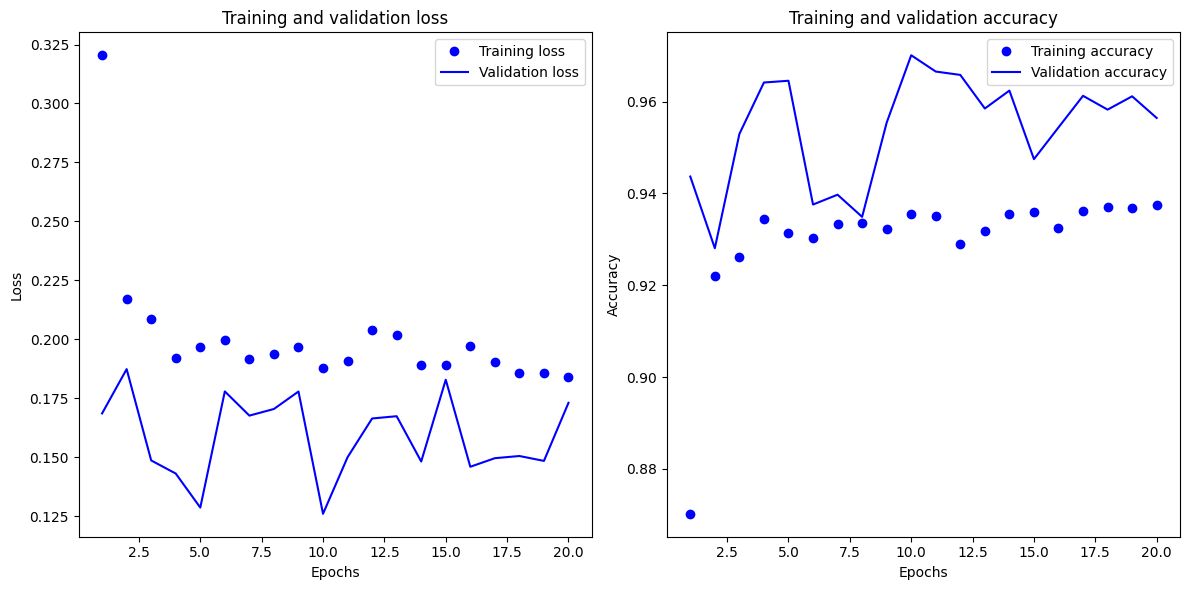

In [20]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1442/1442 [==============================] - 1s 855us/step


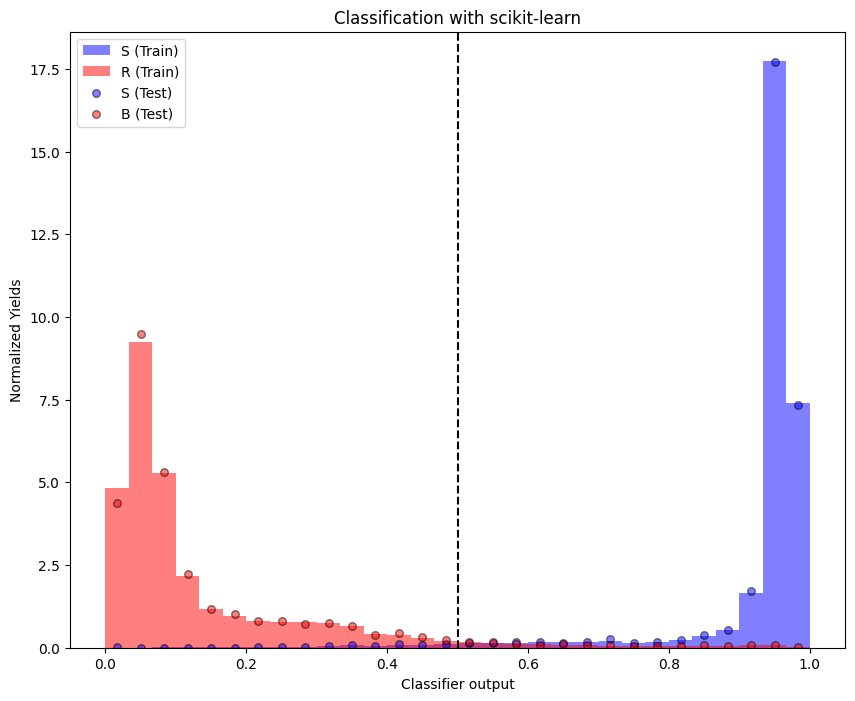

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming you have defined X_train, X_test, y_train, and y_test appropriately
# Load the best model
model = load_model('best_model.h5')

# Model prediction and evaluation
y_train_pred = model.predict(X_train).squeeze()
y_test_pred = model.predict(X_test).squeeze()

y_train_pred_class = (y_train_pred > 0.5).astype(int)
y_test_pred_class = (y_test_pred > 0.5).astype(int)

# Calculate histograms and bins for training data
train_hist_s, bins = np.histogram(y_train_pred[y_train == 1], bins=30, density=True)
train_hist_r, _ = np.histogram(y_train_pred[y_train == 0], bins=bins, density=True)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for training data
plt.figure(figsize=(10, 8))

plt.hist(y_train_pred[y_train == 1], bins=30, color='blue', alpha=0.5, label='S (Train)', density=True)
plt.hist(y_train_pred[y_train == 0], bins=30, color='red', alpha=0.5, label='R (Train)', density=True)

# Plot scatter points for test data over the top of training histograms
plt.scatter(bin_centers, np.histogram(y_test_pred[y_test == 1], bins=bins, density=True)[0], 
            color='blue', alpha=0.5, label='S (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, np.histogram(y_test_pred[y_test == 0], bins=bins, density=True)[0], 
            color='red', alpha=0.5, label='B (Test)', marker='o', s=30, edgecolor='k')

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.legend()
plt.title('Classification with scikit-learn')

# Save and display the plot
# plt.savefig("bdtplots/dnn/classifier_output_plot.png")
# plt.savefig("bdtplots/dnn/classifier_output_plot.pdf")
plt.show()


1442/1442 [==============================] - 1s 817us/step


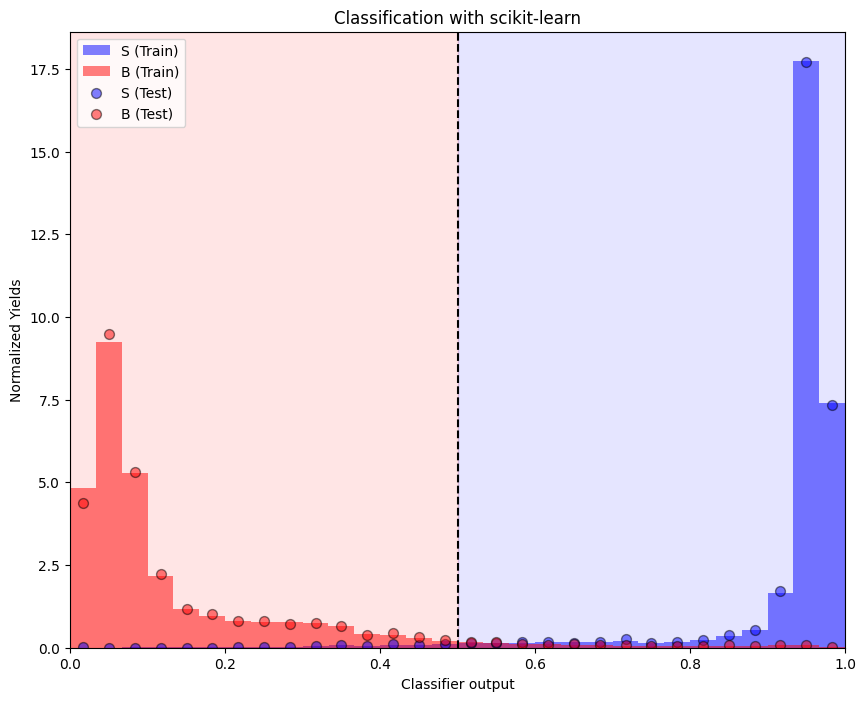

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming you have defined X_train, X_test, y_train, and y_test appropriately
# Load the best model
model = load_model('best_model.h5')

# Model prediction and evaluation
y_train_pred = model.predict(X_train).squeeze()
y_test_pred = model.predict(X_test).squeeze()

y_train_pred_class = (y_train_pred > 0.5).astype(int)
y_test_pred_class = (y_test_pred > 0.5).astype(int)

# Calculate histograms and bins for training data
train_hist_s, bins = np.histogram(y_train_pred[y_train == 1], bins=30, density=True)
train_hist_r, _ = np.histogram(y_train_pred[y_train == 0], bins=bins, density=True)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for training data
plt.figure(figsize=(10, 8))

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.hist(y_train_pred[y_train == 1], bins=30, color='blue', alpha=0.5, label='S (Train)', density=True)
plt.hist(y_train_pred[y_train == 0], bins=30, color='red', alpha=0.5, label='B (Train)', density=True)

# Plot scatter points for test data over the top of training histograms
plt.scatter(bin_centers, np.histogram(y_test_pred[y_test == 1], bins=bins, density=True)[0], 
            color='blue', alpha=0.5, label='S (Test)', marker='o', s=50, edgecolor='k')
plt.scatter(bin_centers, np.histogram(y_test_pred[y_test == 0], bins=bins, density=True)[0], 
            color='red', alpha=0.5, label='B (Test)', marker='o', s=50, edgecolor='k')

plt.axvline(0.5, color='k', linestyle='--')
plt.xlim(0,1)
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.legend()
plt.title('Classification with scikit-learn')

# Save and display the plot
# plt.savefig("bdtplots/dnn/classifier_output_plot.png")
# plt.savefig("bdtplots/dnn/classifier_output_plot.pdf")
plt.show()


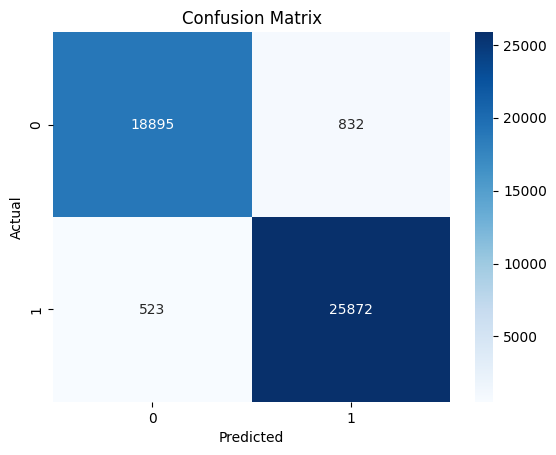

In [23]:
# Confusion Matrix
conf_matrix = pd.crosstab(y_test, y_test_pred_class, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
# plt.savefig("bdtplots/dnn/confusion_matrix.png")
# plt.savefig("bdtplots/dnn/confusion_matrix.pdf")
plt.show()


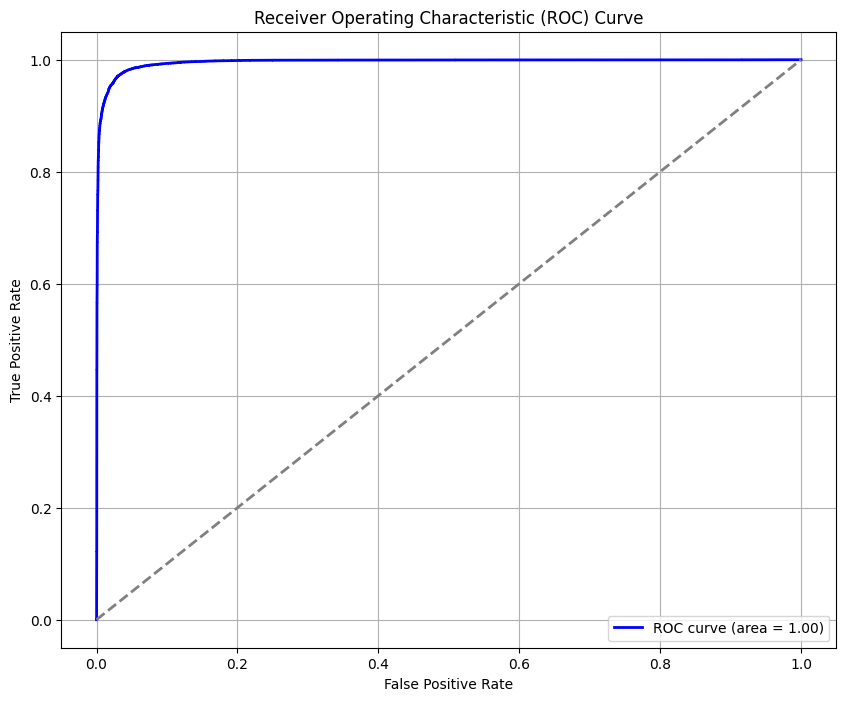

Accuracy on test set: 0.970621395429513
ROC AUC on test set: 0.9955341817590756
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     19727
           1       0.97      0.98      0.97     26395

    accuracy                           0.97     46122
   macro avg       0.97      0.97      0.97     46122
weighted avg       0.97      0.97      0.97     46122



In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
# plt.savefig("bdtplots/dnn/roc_curve.png")
# plt.savefig("bdtplots/dnn/roc_curve.pdf")
plt.show()
plt.close()

print("Accuracy on test set:", accuracy_score(y_test, y_test_pred_class))
print("ROC AUC on test set:", roc_auc_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred_class))


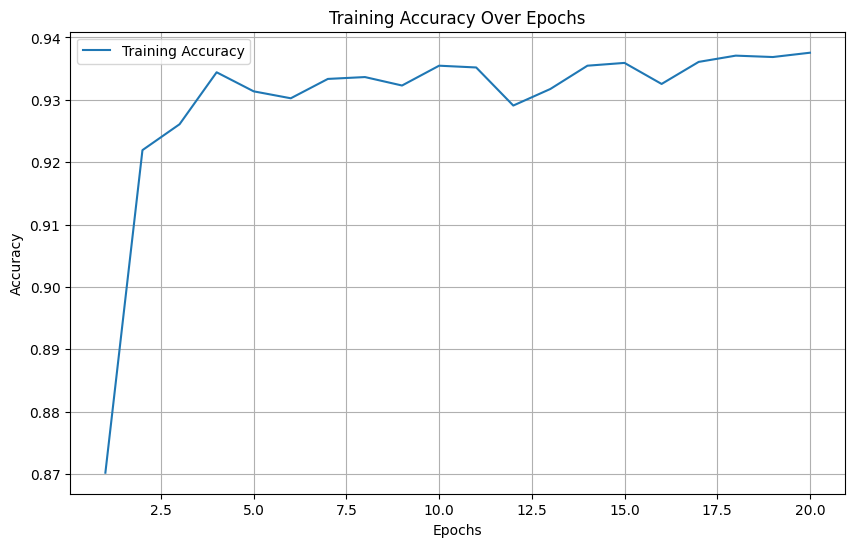

In [25]:

# Assuming `history` is the history object returned by `model.fit`
# Plot training accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("bdtplots/dnn/training_accuracy.png")
plt.show()

### Model improvement: I
This following model will be overtrained

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'], shuffle=True)

# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Define the model
def create_dnn_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Create the model
input_dim = X_train_scaled.shape[1]
model = create_dnn_model(input_dim)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Model summary
model.summary()

# Save the model summary to a file
import os
os.makedirs("bdtplots/dnn", exist_ok=True)
with open("bdtplots/dnn/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    sample_weight=X_train_weights,
                    epochs=50, 
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test, X_test_weights),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Load the best model
model.load_weights('best_model.h5')

import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()